### Objetivo 

### 1. Generacion de datos
- Simular series temporales con o sin señales de ondas gravitacionales, con diferentes relaciones señal/ruido controladas por el parámetro R, para despues entrenar modelos que puedan clasificar si una señal está presente o no.

- Parámetro R: está relacionado con la relación señal/ruido (SNR). Cuanto menor sea R, mayor será el ruido relativo a la señal, y por tanto más difícil de detectar. En la fórmula: $$ s = g + \epsilon \frac{1}{R}\xi $$
  - g: señal de onda gravitacional real (del archivo .npy).
  - ξ: ruido gaussiano estándar.
  - ϵ = 10^−19: escala del ruido.
  - R: ajusta cuán ruidosa será la señal.

In [3]:
import pandas as pd
import numpy as np
from gtda.time_series import SlidingWindow
from gtda.time_series import TakensEmbedding
from pathlib import Path


from gtda.metaestimators import CollectionTransformer
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef, recall_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold


In [2]:
#Funcion para generar los datasets sinteticos de entrenamiento
# MezclandMezcla señales de ondas gravitaciones reales (sin ruido) con ruido gaussiano. 
# Esto simula lo que ocurre en la realidad: los detectores reciben señales muy ruidosas, y se necesita detectar si hay una onda entre ese ruido.
def make_gravitational_waves(  
    path_to_data: Path, #  rRuta al archivo .npy que contiene las señales reales sin ruido.
    n_signals: int = 1000, # Cantidad total de señales a generar (ruido + señal real).
    downsample_factor: int = 2, # Para reducir la resolución temporal de las señales.
    # Aqui se define un rango rango de valores de R, el parámetro que controla el nivel de ruido relativo a la señal
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
    signal_ratio: float = 0.5 # proporción de señales reales en el dataset (el resto será puro ruido).
):
    
    # La funcion padrand inserta inserta la señal en una serie más larga de ruido aleatoriamente
    # Donde V es la señal (sea real o ruido), n es la longitud del padding (ruido) a añadir antes y después, y kr es la escala del ruido 
    # Esto simula cómo en la vida real una onda puede aparecer en cualquier momento dentro de un intervalo temporal.
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out
    # Simula cómo en la vida real una onda puede aparecer en cualquier momento dentro de un intervalo temporal.
    
    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500
    
    # Cargamos el archivo de señales reales sin ruido
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))

    noisy_signals = []
    labels = np.zeros(n_signals)

    n_signal = int(n_signals * signal_ratio)
    signal_indices = np.random.choice(n_signals, size=n_signal, replace=False)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        is_signal = int(j in signal_indices)
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = is_signal
        if is_signal:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())

    return np.array(noisy_signals), labels

EXPERIMENTO OG CON 1000 SEÑALES

In [ ]:
# Generación de CSVs
DATA = Path(".")
embending_dim = 100


n_signals = 1000

R_values = [0.42, 0.535, 0.65]
signal_ratios = [0.5, 0.25, 0.75, 0.1, 0.9]

models = { "LogisticRegression": LogisticRegression(random_state = 34),
          "MLP": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state= 34)}
method = ["takens", "sliding_window"]
resultados = []

# valores para sliding windows
window_size_sw = 5
stride_sw = 1

# valores para takens
embedding_dimension_tk = 200
embedding_time_delay_tk = 10
stride_tk = 10



for r in R_values:
    for ratio in signal_ratios:
        noisy_signals, labels = make_gravitational_waves(
            path_to_data=DATA,
            n_signals=n_signals,
            r_min=r,
            r_max=r,
            n_snr_values=1,
            signal_ratio=ratio
        )
        
        # construccion del pipeline
        for m in method:
            
            if m == "sliding_window":
                embedder = SlidingWindow(size=window_size_sw, stride=stride_sw)
            else:
                embedder = TakensEmbedding(time_delay=embedding_time_delay_tk,
                           dimension=embedding_dimension_tk,
                           stride=stride_tk)
            
            batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)
            persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
            scaling = Scaler()
            entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

            # ensamblamos el pipeline
            steps = [
                    ("embedder", embedder),
                    ("pca", batch_pca),
                    ("persistence", persistence),
                    ("scaling", scaling),
                    ("entropy", entropy)
                    ]


            topological_pipeline = Pipeline(steps)
            features =  topological_pipeline.fit_transform(noisy_signals)
            
            # caso específico del slidinw window, tenemos que hacer un recorte
            # de los labels para que hagan match con las señales porque la librería de 
            # giotto-TDA quita por default varias señales y hace un error 
            if features.shape[0] < labels.shape[0]:
                labels = labels[:features.shape[0]]
            
            # dividimos los datos
            X_train, X_valid, y_train, y_valid = train_test_split(
                features, labels, test_size = 0.2, random_state = 34
            )
            
            # entrenamos los modelos
            for model_name, model in models.items():
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_valid)
                    
                    acc = accuracy_score(y_valid, y_pred)
                    recall = recall_score(y_valid, y_pred)
                    mcc = matthews_corrcoef(y_valid, y_pred)

                    resultados.append({
                        "R": r,
                        "signal_ratio": ratio,
                        "embedding_method": m,
                        "model": model_name,
                        "n_samples": features.shape[0],
                        "acc": acc,
                        "recall": recall,
                        "mcc": mcc,
                    })

                    print(f"✅ R={r}, ratio={ratio}, method={m}, model={model_name}, acc={acc:.3f}, recall={recall:.3f}, mcc={mcc:.3f}")
                except Exception as e:
                    print(f"❌ Error con R={r}, ratio={ratio}, method={m}, model={model_name}: {e}")

                      

✅ R=0.42, ratio=0.5, method=takens, model=LogisticRegression, acc=0.535, recall=0.343, mcc=0.113
✅ R=0.42, ratio=0.5, method=takens, model=MLP, acc=0.460, recall=0.000, mcc=0.000
✅ R=0.42, ratio=0.5, method=sliding_window, model=LogisticRegression, acc=0.550, recall=0.680, mcc=0.104
✅ R=0.42, ratio=0.5, method=sliding_window, model=MLP, acc=0.555, recall=0.770, mcc=0.122
✅ R=0.42, ratio=0.25, method=takens, model=LogisticRegression, acc=0.765, recall=0.000, mcc=0.000
✅ R=0.42, ratio=0.25, method=takens, model=MLP, acc=0.765, recall=0.000, mcc=0.000
✅ R=0.42, ratio=0.25, method=sliding_window, model=LogisticRegression, acc=0.690, recall=0.000, mcc=0.000
✅ R=0.42, ratio=0.25, method=sliding_window, model=MLP, acc=0.690, recall=0.000, mcc=0.000
✅ R=0.42, ratio=0.75, method=takens, model=LogisticRegression, acc=0.740, recall=1.000, mcc=0.000
✅ R=0.42, ratio=0.75, method=takens, model=MLP, acc=0.740, recall=1.000, mcc=0.000
✅ R=0.42, ratio=0.75, method=sliding_window, model=LogisticRegressi

c:\Users\Coord-Personal\miniconda3\envs\tda-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ R=0.535, ratio=0.5, method=takens, model=MLP, acc=0.640, recall=0.546, mcc=0.280
✅ R=0.535, ratio=0.5, method=sliding_window, model=LogisticRegression, acc=0.535, recall=0.757, mcc=0.063
✅ R=0.535, ratio=0.5, method=sliding_window, model=MLP, acc=0.535, recall=0.757, mcc=0.063
✅ R=0.535, ratio=0.25, method=takens, model=LogisticRegression, acc=0.755, recall=0.109, mcc=0.286
✅ R=0.535, ratio=0.25, method=takens, model=MLP, acc=0.725, recall=0.000, mcc=0.000
✅ R=0.535, ratio=0.25, method=sliding_window, model=LogisticRegression, acc=0.740, recall=0.000, mcc=0.000
✅ R=0.535, ratio=0.25, method=sliding_window, model=MLP, acc=0.740, recall=0.000, mcc=0.000
✅ R=0.535, ratio=0.75, method=takens, model=LogisticRegression, acc=0.750, recall=1.000, mcc=0.121
✅ R=0.535, ratio=0.75, method=takens, model=MLP, acc=0.745, recall=1.000, mcc=0.000
✅ R=0.535, ratio=0.75, method=sliding_window, model=LogisticRegression, acc=0.755, recall=1.000, mcc=0.000
✅ R=0.535, ratio=0.75, method=sliding_window, mo

c:\Users\Coord-Personal\miniconda3\envs\tda-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ R=0.65, ratio=0.5, method=takens, model=MLP, acc=0.655, recall=0.630, mcc=0.310
✅ R=0.65, ratio=0.5, method=sliding_window, model=LogisticRegression, acc=0.505, recall=0.808, mcc=-0.020
✅ R=0.65, ratio=0.5, method=sliding_window, model=MLP, acc=0.505, recall=0.808, mcc=-0.020
✅ R=0.65, ratio=0.25, method=takens, model=LogisticRegression, acc=0.830, recall=0.128, mcc=0.325


c:\Users\Coord-Personal\miniconda3\envs\tda-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ R=0.65, ratio=0.25, method=takens, model=MLP, acc=0.830, recall=0.128, mcc=0.325
✅ R=0.65, ratio=0.25, method=sliding_window, model=LogisticRegression, acc=0.775, recall=0.000, mcc=0.000
✅ R=0.65, ratio=0.25, method=sliding_window, model=MLP, acc=0.775, recall=0.000, mcc=0.000
✅ R=0.65, ratio=0.75, method=takens, model=LogisticRegression, acc=0.725, recall=1.000, mcc=0.114
✅ R=0.65, ratio=0.75, method=takens, model=MLP, acc=0.720, recall=1.000, mcc=0.000
✅ R=0.65, ratio=0.75, method=sliding_window, model=LogisticRegression, acc=0.745, recall=1.000, mcc=0.000
✅ R=0.65, ratio=0.75, method=sliding_window, model=MLP, acc=0.745, recall=1.000, mcc=0.000
✅ R=0.65, ratio=0.1, method=takens, model=LogisticRegression, acc=0.915, recall=0.000, mcc=0.000
✅ R=0.65, ratio=0.1, method=takens, model=MLP, acc=0.915, recall=0.000, mcc=0.000
✅ R=0.65, ratio=0.1, method=sliding_window, model=LogisticRegression, acc=0.910, recall=0.000, mcc=0.000
✅ R=0.65, ratio=0.1, method=sliding_window, model=MLP, acc

experimento con 10 iteraciones y CV solo con 100 señales

In [12]:
# Generación de CSVs
DATA = Path(".")
embending_dim = 100


n_signals = 100

R_values = [0.42, 0.535, 0.65]
signal_ratios = [0.5, 0.25, 0.75, 0.1, 0.9]

models = { "LogisticRegression": LogisticRegression(random_state = 34),
          "MLP": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state= 34)}
method = ["takens", "sliding_window"]
resultados = []
iteraciones = 10

# cross validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)

# metricas de evaluación
metricas = {
    "accuracy": "accuracy",
    "recall": "recall"
}



# valores para sliding windows
window_size_sw = 5
stride_sw = 1

# valores para takens
embedding_dimension_tk = 200
embedding_time_delay_tk = 10
stride_tk = 10


for iter in range(iteraciones):
    print(f"\n--- Iteración {iter + 1}/{iteraciones} ---")
    for r in R_values:
        for ratio in signal_ratios:
            
            noisy_signals, labels = make_gravitational_waves(
                path_to_data=DATA,
                n_signals=n_signals,
                r_min=r,
                r_max=r,
                n_snr_values=1,
                signal_ratio=ratio
            )
            
            # construccion del pipeline
            for m in method:
                
                if m == "sliding_window":
                    embedder = SlidingWindow(size=window_size_sw, stride=stride_sw)
                else:
                    embedder = TakensEmbedding(time_delay=embedding_time_delay_tk,
                            dimension=embedding_dimension_tk,
                            stride=stride_tk)
                
                batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)
                persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
                scaling = Scaler()
                entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

                # ensamblamos el pipeline
                steps = [
                        ("embedder", embedder),
                        ("pca", batch_pca),
                        ("persistence", persistence),
                        ("scaling", scaling),
                        ("entropy", entropy)
                        ]


                topological_pipeline = Pipeline(steps)
                features =  topological_pipeline.fit_transform(noisy_signals)
                
                # caso específico del slidinw window, tenemos que hacer un recorte
                # de los labels para que hagan match con las señales porque la librería de 
                # giotto-TDA quita por default varias señales y hace un error 
                if features.shape[0] < labels.shape[0]:
                    labels = labels[:features.shape[0]]
                
                
                # entrenamos los modelos
                for model_name, model in models.items():
                    try:
                        cv_results = cross_validate(
                            model, features, labels, cv = cv, scoring=metricas
                        )

                        resultados.append({
                            "iteracion": iter + 1,
                            "R": r,
                            "signal_ratio": ratio,
                            "embedding_method": m,
                            "model": model_name,
                            "acc_mean": cv_results["test_accuracy"].mean(),
                            "acc_std": cv_results["test_accuracy"].std(),  # Track variance!
                            "recall_mean": cv_results["test_recall"].mean(),
                            "recall_std": cv_results["test_recall"].std(),
                        })

                        print(f"✅ R={r}, ratio={ratio}, method={m}, model={model_name}, "
                            f"acc={cv_results['test_accuracy'].mean():.3f}±{cv_results['test_accuracy'].std():.3f}, "
                            f"recall={cv_results['test_recall'].mean():.3f}±{cv_results['test_recall'].std():.3f}")
                    
                    except Exception as e:
                        print(f"❌ Error con R={r}, ratio={ratio}, method={m}, model={model_name}: {e}")

                      


--- Iteración 1/10 ---
✅ R=0.42, ratio=0.5, method=takens, model=LogisticRegression, acc=0.500±0.063, recall=0.540±0.049
✅ R=0.42, ratio=0.5, method=takens, model=MLP, acc=0.500±0.000, recall=1.000±0.000
✅ R=0.42, ratio=0.5, method=sliding_window, model=LogisticRegression, acc=0.613±0.146, recall=0.587±0.075
✅ R=0.42, ratio=0.5, method=sliding_window, model=MLP, acc=0.603±0.164, recall=0.567±0.103
✅ R=0.42, ratio=0.25, method=takens, model=LogisticRegression, acc=0.750±0.000, recall=0.000±0.000
✅ R=0.42, ratio=0.25, method=takens, model=MLP, acc=0.750±0.000, recall=0.000±0.000
✅ R=0.42, ratio=0.25, method=sliding_window, model=LogisticRegression, acc=0.750±0.020, recall=0.000±0.000
✅ R=0.42, ratio=0.25, method=sliding_window, model=MLP, acc=0.750±0.020, recall=0.000±0.000
✅ R=0.42, ratio=0.75, method=takens, model=LogisticRegression, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.42, ratio=0.75, method=takens, model=MLP, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.42, ratio=0.75, method=slid

c:\Users\Coord-Personal\miniconda3\envs\tda-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ R=0.42, ratio=0.25, method=sliding_window, model=MLP, acc=0.739±0.005, recall=0.000±0.000
✅ R=0.42, ratio=0.75, method=takens, model=LogisticRegression, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.42, ratio=0.75, method=takens, model=MLP, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.42, ratio=0.75, method=sliding_window, model=LogisticRegression, acc=0.739±0.005, recall=1.000±0.000
✅ R=0.42, ratio=0.75, method=sliding_window, model=MLP, acc=0.739±0.005, recall=1.000±0.000
✅ R=0.42, ratio=0.1, method=takens, model=LogisticRegression, acc=0.900±0.000, recall=0.000±0.000
✅ R=0.42, ratio=0.1, method=takens, model=MLP, acc=0.900±0.000, recall=0.000±0.000
✅ R=0.42, ratio=0.1, method=sliding_window, model=LogisticRegression, acc=0.906±0.021, recall=0.000±0.000
✅ R=0.42, ratio=0.1, method=sliding_window, model=MLP, acc=0.906±0.021, recall=0.000±0.000
✅ R=0.42, ratio=0.9, method=takens, model=LogisticRegression, acc=0.900±0.000, recall=1.000±0.000
✅ R=0.42, ratio=0.9, method=takens, model=MLP, acc

c:\Users\Coord-Personal\miniconda3\envs\tda-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ R=0.65, ratio=0.25, method=sliding_window, model=MLP, acc=0.761±0.024, recall=0.000±0.000
✅ R=0.65, ratio=0.75, method=takens, model=LogisticRegression, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.65, ratio=0.75, method=takens, model=MLP, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.65, ratio=0.75, method=sliding_window, model=LogisticRegression, acc=0.739±0.005, recall=1.000±0.000
✅ R=0.65, ratio=0.75, method=sliding_window, model=MLP, acc=0.739±0.005, recall=1.000±0.000
✅ R=0.65, ratio=0.1, method=takens, model=LogisticRegression, acc=0.900±0.000, recall=0.000±0.000
✅ R=0.65, ratio=0.1, method=takens, model=MLP, acc=0.900±0.000, recall=0.000±0.000
✅ R=0.65, ratio=0.1, method=sliding_window, model=LogisticRegression, acc=0.896±0.002, recall=0.000±0.000
✅ R=0.65, ratio=0.1, method=sliding_window, model=MLP, acc=0.896±0.002, recall=0.000±0.000
✅ R=0.65, ratio=0.9, method=takens, model=LogisticRegression, acc=0.900±0.000, recall=1.000±0.000
✅ R=0.65, ratio=0.9, method=takens, model=MLP, acc

c:\Users\Coord-Personal\miniconda3\envs\tda-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ R=0.65, ratio=0.25, method=sliding_window, model=MLP, acc=0.771±0.023, recall=0.000±0.000
✅ R=0.65, ratio=0.75, method=takens, model=LogisticRegression, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.65, ratio=0.75, method=takens, model=MLP, acc=0.750±0.000, recall=1.000±0.000
✅ R=0.65, ratio=0.75, method=sliding_window, model=LogisticRegression, acc=0.750±0.020, recall=1.000±0.000
✅ R=0.65, ratio=0.75, method=sliding_window, model=MLP, acc=0.750±0.020, recall=1.000±0.000
✅ R=0.65, ratio=0.1, method=takens, model=LogisticRegression, acc=0.900±0.000, recall=0.000±0.000
✅ R=0.65, ratio=0.1, method=takens, model=MLP, acc=0.900±0.000, recall=0.000±0.000
✅ R=0.65, ratio=0.1, method=sliding_window, model=LogisticRegression, acc=0.896±0.002, recall=0.000±0.000


c:\Users\Coord-Personal\miniconda3\envs\tda-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ R=0.65, ratio=0.1, method=sliding_window, model=MLP, acc=0.896±0.002, recall=0.000±0.000
✅ R=0.65, ratio=0.9, method=takens, model=LogisticRegression, acc=0.900±0.000, recall=1.000±0.000
✅ R=0.65, ratio=0.9, method=takens, model=MLP, acc=0.900±0.000, recall=1.000±0.000
✅ R=0.65, ratio=0.9, method=sliding_window, model=LogisticRegression, acc=0.896±0.002, recall=1.000±0.000
✅ R=0.65, ratio=0.9, method=sliding_window, model=MLP, acc=0.896±0.002, recall=1.000±0.000

--- Iteración 7/10 ---
✅ R=0.42, ratio=0.5, method=takens, model=LogisticRegression, acc=0.610±0.080, recall=0.500±0.126
✅ R=0.42, ratio=0.5, method=takens, model=MLP, acc=0.500±0.000, recall=1.000±0.000
✅ R=0.42, ratio=0.5, method=sliding_window, model=LogisticRegression, acc=0.489±0.039, recall=0.540±0.320
✅ R=0.42, ratio=0.5, method=sliding_window, model=MLP, acc=0.521±0.011, recall=1.000±0.000
✅ R=0.42, ratio=0.25, method=takens, model=LogisticRegression, acc=0.750±0.000, recall=0.000±0.000
✅ R=0.42, ratio=0.25, method=t

In [13]:
data_rs = pd.DataFrame(resultados)

In [14]:
data_rs 

,iteracion,R,signal_ratio,embedding_method,model,acc_mean,acc_std,recall_mean,recall_std
0,1,0.42,0.50,takens,LogisticRegression,0.500000,0.063246,0.540000,0.048990
1,1,0.42,0.50,takens,MLP,0.500000,0.000000,1.000000,0.000000
2,1,0.42,0.50,sliding_window,LogisticRegression,0.613158,0.145952,0.586667,0.074833
3,1,0.42,0.50,sliding_window,MLP,0.602632,0.164005,0.566667,0.103280
4,1,0.42,0.25,takens,LogisticRegression,0.750000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
595,10,0.65,0.10,sliding_window,MLP,0.895789,0.002105,0.000000,0.000000
596,10,0.65,0.90,takens,LogisticRegression,0.900000,0.000000,1.000000,0.000000
597,10,0.65,0.90,takens,MLP,0.900000,0.000000,1.000000,0.000000
598,10,0.65,0.90,sliding_window,LogisticRegression,0.895789,0.002105,1.000000,0.000000


In [15]:
data_rs.to_csv("resultados_tda_completos.csv", index=False)

In [16]:
data_rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iteracion         600 non-null    int64  
 1   R                 600 non-null    float64
 2   signal_ratio      600 non-null    float64
 3   embedding_method  600 non-null    object 
 4   model             600 non-null    object 
 5   acc_mean          600 non-null    float64
 6   acc_std           600 non-null    float64
 7   recall_mean       600 non-null    float64
 8   recall_std        600 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 42.3+ KB


In [53]:
data_rs["combination"] = (
    data_rs["embedding_method"].astype(str) + "_" +
    data_rs["model"].astype(str)
)

In [54]:
data_rs

,iteracion,R,signal_ratio,embedding_method,model,acc_mean,acc_std,recall_mean,recall_std,combination
0,1,0.42,0.50,takens,LogisticRegression,0.500000,0.063246,0.540000,0.048990,takens_LogisticRegression
1,1,0.42,0.50,takens,MLP,0.500000,0.000000,1.000000,0.000000,takens_MLP
2,1,0.42,0.50,sliding_window,LogisticRegression,0.613158,0.145952,0.586667,0.074833,sliding_window_LogisticRegression
3,1,0.42,0.50,sliding_window,MLP,0.602632,0.164005,0.566667,0.103280,sliding_window_MLP
4,1,0.42,0.25,takens,LogisticRegression,0.750000,0.000000,0.000000,0.000000,takens_LogisticRegression
...,...,...,...,...,...,...,...,...,...,...
595,10,0.65,0.10,sliding_window,MLP,0.895789,0.002105,0.000000,0.000000,sliding_window_MLP
596,10,0.65,0.90,takens,LogisticRegression,0.900000,0.000000,1.000000,0.000000,takens_LogisticRegression
597,10,0.65,0.90,takens,MLP,0.900000,0.000000,1.000000,0.000000,takens_MLP
598,10,0.65,0.90,sliding_window,LogisticRegression,0.895789,0.002105,1.000000,0.000000,sliding_window_LogisticRegression


In [57]:
data_rs.groupby("R")["combination"].value_counts()

R      combination                      
0.420  sliding_window_LogisticRegression    50
       sliding_window_MLP                   50
       takens_LogisticRegression            50
       takens_MLP                           50
0.535  sliding_window_LogisticRegression    50
       sliding_window_MLP                   50
       takens_LogisticRegression            50
       takens_MLP                           50
0.650  sliding_window_LogisticRegression    50
       sliding_window_MLP                   50
       takens_LogisticRegression            50
       takens_MLP                           50
Name: count, dtype: int64

## Pruebas estadísticas

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns 

* Hagamos un análisis inicial para ver la distribución de valores para recall y accuracy

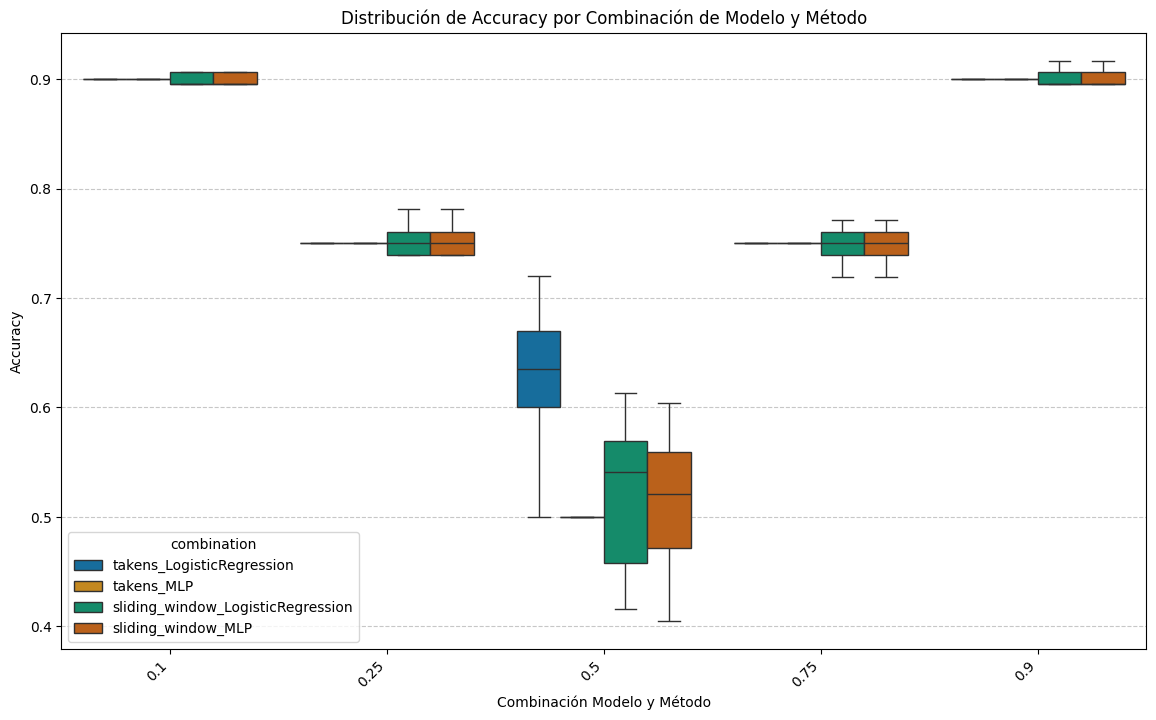

In [70]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_rs, x="signal_ratio", y="acc_mean", hue = "combination", palette="colorblind")
plt.xticks(rotation=45, ha="right")
plt.title("Distribución de Accuracy por Combinación de Modelo y Método")
plt.xlabel("Combinación Modelo y Método")
plt.ylabel("Accuracy")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(r"C:\Users\Coord-Personal\Documents\ITZELT\TEC\UNII\SEXTO_SEMESTRE\topologia\compu_topology\RETO\distribucion_acc.png")
plt.show()

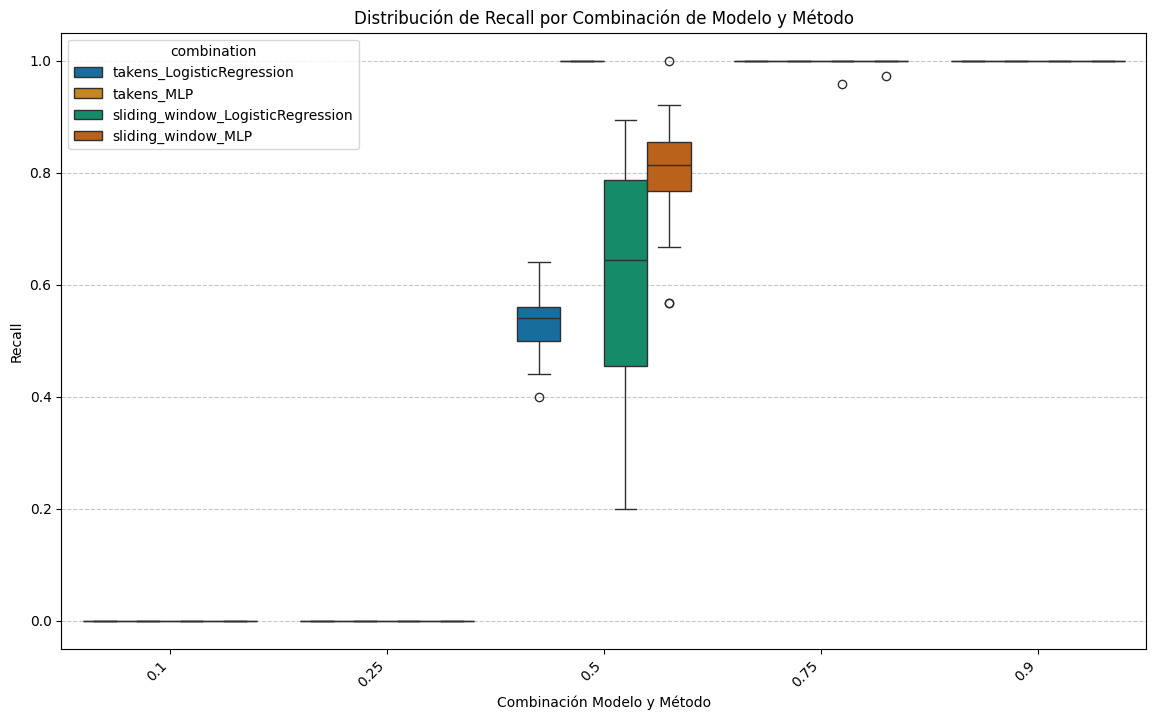

In [71]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_rs, x="signal_ratio", y="recall_mean", hue = "combination", palette="colorblind")
plt.xticks(rotation=45, ha="right")
plt.title("Distribución de Recall por Combinación de Modelo y Método")
plt.xlabel("Combinación Modelo y Método")
plt.ylabel("Recall")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(r"C:\Users\Coord-Personal\Documents\ITZELT\TEC\UNII\SEXTO_SEMESTRE\topologia\compu_topology\RETO\distribucion_recall.png")
plt.show()

In [67]:
# Agrupar por combinación y calcular estadísticas
summary_table = data_rs.groupby(['R','embedding_method', 'model']).agg({
    'acc_mean': ['mean', 'std'],
    'recall_mean': ['mean', 'std']
}).reset_index()

# Renombrar columnas para claridad
summary_table.columns = ['R', 'Método', 'Modelo', 
                         'Accuracy (mean)', 'Accuracy (std)', 
                         'Recall (mean)', 'Recall (std)']

# Exportar a LaTeX (formateo opcional)
summary_table.to_latex(
    "summary_table.tex",
    index=False,
    float_format="%.3f",  # 3 decimales
    caption="Resumen de métricas por combinación de parámetros",
    label="tab:stats"
)

Aplicamos la prueba Kruskal Wallis para ver si hay diferencias significativas en las combinaciones!

In [62]:
from scipy.stats import kruskal

kruskal_results_R = {}

for R_val in data_rs['R'].unique():
    subset = data_rs[data_rs['R'] == R_val]
    groups = [group['recall_mean'].values for _, group in subset.groupby('combination')]
    
    stat, pval = kruskal(*groups)
    kruskal_results_R[R_val] = (stat, pval)

# Imprimir resultados
for R_val, (stat, pval) in kruskal_results_R.items():
    print(f"R = {R_val}: Estadístico = {stat:.2f}, p-value = {pval:.4f}")
    if pval < 0.05:
        print("  → Diferencias significativas entre combinaciones de modelo y metodo\n")
    else:
        print("  → No hay diferencias significativas\n")

R = 0.42: Estadístico = 1.95, p-value = 0.5838
  → No hay diferencias significativas

R = 0.535: Estadístico = 1.98, p-value = 0.5776
  → No hay diferencias significativas

R = 0.65: Estadístico = 2.19, p-value = 0.5332
  → No hay diferencias significativas

